# Vowpal Wabbit Contextual Bandit

## Contextual bandit with changing context
> Customizing the context and changing it midway to see how fast the agent can adapt to the new context and start recommending better products as per the context

In [ ]:
!pip install -q vowpalwabbit

In [ ]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product

### Setting the context

In [ ]:
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [ ]:
users = ['A','B','C']
items = ['Item1','Item2','Item3','Item4','Item5','Item6']
context1 = ['morning','evening']
context2 = ['summer','winter']

context = pd.DataFrame(list(product(users, context1, context2, items)), columns=['users', 'context1', 'context2', 'items'])
context['reward'] = 0

#user 1 likes Item 1 in morning, and Item 6 in summer
context.loc[(context.users=='A') & \
            (context.context1=='morning') & \
            (context['items']=='Item1'), \
            'reward'] = 1
context.loc[(context.users=='A') & \
            (context.context2=='summer') & \
            (context['items']=='Item6'), \
            'reward'] = 1

#user 2 likes Item 2 in winter, and Item 5 in summer morning
context.loc[(context.users=='B') & \
            (context.context2=='winter') & \
            (context['items']=='Item2'), \
            'reward'] = 1
context.loc[(context.users=='B') & \
            (context.context1=='morning') & \
            (context.context2=='summer') & \
            (context['items']=='Item5'), \
            'reward'] = 1


#user 3 likes Item 2 in morning, Item 3 in evening, and item 4 in winter morning
context.loc[(context.users=='C') & \
            (context.context1=='morning') & \
            (context['items']=='Item2'), \
            'reward'] = 1
context.loc[(context.users=='C') & \
            (context.context1=='evening') & \
            (context['items']=='Item3'), \
            'reward'] = 1
context.loc[(context.users=='C') & \
            (context.context1=='morning') & \
            (context.context2=='winter') & \
            (context['items']=='Item4'), \
            'reward'] = 1

context['cost'] = context['reward']*-1

contextdf = context.copy()

In [ ]:
contextdf.cost.value_counts()

 0    60
-1    12
Name: cost, dtype: int64

### Cost function util

In [ ]:
def get_cost(context,action):
    return contextdf.loc[(contextdf['users']==context['user']) & \
            (contextdf.context1==context['context1']) & \
            (contextdf.context2==context['context2']) & \
            (contextdf['items']==action), \
            'cost'].values[0]

In [ ]:
get_cost({'user':'A','context1':'morning','context2':'summer'},'Item2')

0

### Vowpalwabbit format util

In [ ]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User users={} context1={} context2={}\n".format(context["user"], context["context1"], context["context2"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action items={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [ ]:
context = {"user":"A","context1":"morning","context2":"summer"}

print(to_vw_example_format(context,items))

shared |User users=A context1=morning context2=summer
|Action items=Item1 
|Action items=Item2 
|Action items=Item3 
|Action items=Item4 
|Action items=Item5 
|Action items=Item6 


In [ ]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [ ]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [ ]:
def choose_user(users):
    return random.choice(users)

def choose_context1(context1):
    return random.choice(context1)

def choose_context2(context2):
    return random.choice(context2)

In [ ]:
def run_simulation(vw, num_iterations, users, contexts1, contexts2, actions, cost_function, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        user = choose_user(users)
        context1 = choose_context1(contexts1)
        context2 = choose_context2(contexts2)

        context = {'user': user, 'context1': context1, 'context2': context2}
        # print(context)
        action, prob = get_action(vw, context, actions)
        # print(action, prob)

        cost = cost_function(context, action)
        # print(cost)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)
            # 7. Let VW know you're done with these objects
            vw.finish_example(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)

    return ctr

In [ ]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

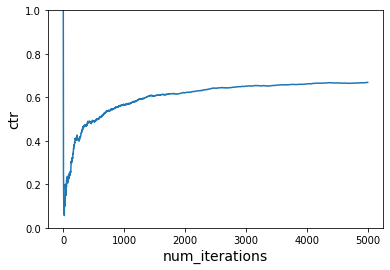

In [ ]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, context1, context2, items, get_cost)

plot_ctr(num_iterations, ctr)

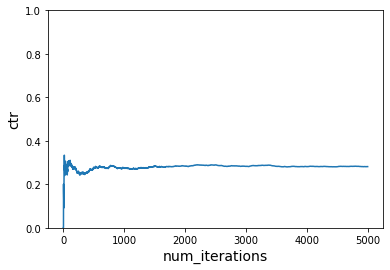

In [ ]:
# Instantiate learner in VW but without -q
vw = pyvw.vw("--cb_explore_adf --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, context1, context2, items, get_cost)

plot_ctr(num_iterations, ctr)

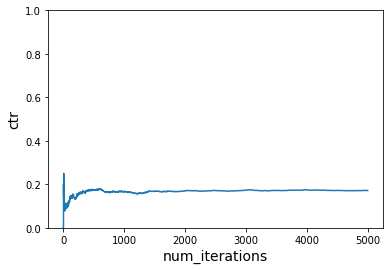

In [ ]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, context1, context2, items, get_cost, do_learn=False)

plot_ctr(num_iterations, ctr)

In [ ]:
users = ['A','B','C']
items = ['Item1','Item2','Item3','Item4','Item5','Item6']
context1 = ['morning','evening']
context2 = ['summer','winter']

context = pd.DataFrame(list(product(users, context1, context2, items)), columns=['users', 'context1', 'context2', 'items'])
context['reward'] = 0

#user 1 likes Item 2 in morning, and Item 5 in summer
context.loc[(context.users=='A') & \
            (context.context1=='morning') & \
            (context['items']=='Item2'), \
            'reward'] = 1
context.loc[(context.users=='A') & \
            (context.context2=='summer') & \
            (context['items']=='Item5'), \
            'reward'] = 1

#user 2 likes Item 2 in summer, and Item 5 in morning
context.loc[(context.users=='B') & \
            (context.context2=='summer') & \
            (context['items']=='Item2'), \
            'reward'] = 1
context.loc[(context.users=='B') & \
            (context.context1=='morning') & \
            (context['items']=='Item5'), \
            'reward'] = 1


#user 3 likes Item 4 in morning, Item 3 in evening, and item 4 in winter evening
context.loc[(context.users=='C') & \
            (context.context1=='morning') & \
            (context['items']=='Item4'), \
            'reward'] = 1
context.loc[(context.users=='C') & \
            (context.context1=='evening') & \
            (context['items']=='Item3'), \
            'reward'] = 1
context.loc[(context.users=='C') & \
            (context.context1=='evening') & \
            (context.context2=='winter') & \
            (context['items']=='Item4'), \
            'reward'] = 1

context['cost'] = context['reward']*-1

contextdf_new = context.copy()

def get_cost_new1(context,action):
    return contextdf_new.loc[(contextdf_new['users']==context['user']) & \
            (contextdf_new.context1==context['context1']) & \
            (contextdf_new.context2==context['context2']) & \
            (contextdf_new['items']==action), \
            'cost'].values[0]

In [ ]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, contexts1, contexts2, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
          user = choose_user(users)
          context1 = choose_context1(contexts1)
          context2 = choose_context2(contexts2)

          context = {'user': user, 'context1': context1, 'context2': context2}
          
          action, prob = get_action(vw, context, actions)
          cost = cost_function(context, action)
          cost_sum += cost

          if do_learn:
              vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
              vw.learn(vw_format)

          ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

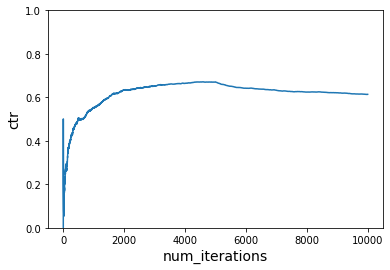

In [ ]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, context1, context2, items, cost_functions)

plot_ctr(total_iterations, ctr)

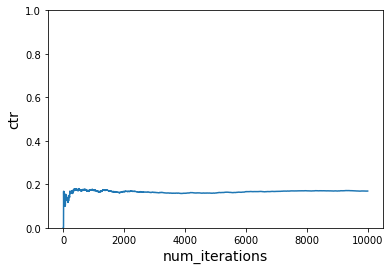

In [ ]:
# Do not learn
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, context1, context2, items, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)

## Contextual bandit with changing context part 2
> Customizing the context and changing it midway to see how fast the agent can adapt to the new context and start recommending better products as per the context.

In [ ]:
mapping_users = {
    'Alex':'usera',
    'Ben':'userb',
    'Cindy': 'userc'
}
    
mapping_context1 = {
    'Morning':'ctx11',
    'Evening':'ctx12',
}

mapping_context2 = {
    'Summer':'ctx21',
    'Winter':'ctx22'
}

mapping_items = {
    'Politics':'item1',
    'Economics':'item2',
    'Technology':'item3',
    'Movies':'item4',
    'Business':'item5',
    'History':'item6'
}

# {v:k for k,v in mappings.items()}

In [ ]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product

In [ ]:
users = list(mapping_users.values())
items = list(mapping_items.values())
context1 = list(mapping_context1.values())
context2 = list(mapping_context2.values())

In [ ]:
context = pd.DataFrame(list(product(users, context1, context2, items)), columns=['users', 'context1', 'context2', 'items'])
context['reward'] = np.random.choice([0,1],len(context))
context['cost'] = context['reward']*-1
contextdf = context.copy()

In [ ]:
contextdf

,users,context1,context2,items,reward,cost
0,usera,ctx11,ctx21,item1,1,-1
1,usera,ctx11,ctx21,item2,1,-1
2,usera,ctx11,ctx21,item3,1,-1
3,usera,ctx11,ctx21,item4,0,0
4,usera,ctx11,ctx21,item5,0,0
...,...,...,...,...,...,...
67,userc,ctx12,ctx22,item2,0,0
68,userc,ctx12,ctx22,item3,0,0
69,userc,ctx12,ctx22,item4,1,-1
70,userc,ctx12,ctx22,item5,1,-1


In [ ]:
import numpy as np
import scipy
import scipy.stats as stats
from vowpalwabbit import pyvw
import random
import pandas as pd
from itertools import product

In [ ]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label=None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User users={} context1={} context2={}\n".format(context["user"], context["context1"], context["context2"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action items={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context, actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob
def choose_user(users):
    return random.choice(users)
def choose_context1(context1):
    return random.choice(context1)
def choose_context2(context2):
    return random.choice(context2)

In [ ]:
class VWCSimulation():
    def __init__(self, vw, ictxt, n=100000):
        self.vw = vw
        self.users = ictxt['users'].unique().tolist()
        self.contexts1 = ictxt['context1'].unique().tolist()
        self.contexts2 = ictxt['context2'].unique().tolist()
        self.actions = ictxt['items'].unique().tolist()
        self.contextdf = ictxt.copy()
        self.contextdf['cost'] = self.contextdf['reward']*-1
        
    def get_cost(self, context, action):
        return self.contextdf.loc[(self.contextdf['users']==context['user']) & \
                (self.contextdf.context1==context['context1']) & \
                (self.contextdf.context2==context['context2']) & \
                (self.contextdf['items']==action), \
                'cost'].values[0]
    
    def update_context(self, new_ctxt):
        self.contextdf = new_ctxt.copy()
        self.contextdf['cost'] = self.contextdf['reward']*-1
    
    def step(self):
        user = choose_user(self.users)
        context1 = choose_context1(self.contexts1)
        context2 = choose_context2(self.contexts2)
        context = {'user': user, 'context1': context1, 'context2': context2}
        action, prob = get_action(self.vw, context, self.actions)
        cost = self.get_cost(context, action)
        vw_format = self.vw.parse(to_vw_example_format(context, self.actions, (action, cost, prob)), pyvw.vw.lContextualBandit)
        self.vw.learn(vw_format)
        self.vw.finish_example(vw_format)
        return (context['user'], context['context1'], context['context2'], action, cost, prob)

In [ ]:
context = pd.DataFrame(list(product(users, context1, context2, items)), columns=['users', 'context1', 'context2', 'items'])
context['reward'] = np.random.choice([0,1],len(context),p=[0.8,0.2])
contextdf = context.copy()
contextdf.reward.value_counts()

0    61
1    11
Name: reward, dtype: int64

In [ ]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")
vws = VWCSimulation(vw, contextdf)

In [ ]:
vws.step()

('usera', 'ctx11', 'ctx22', 'item4', 0, 0.16666666666666666)

In [ ]:
_temp = []
for i in range(5000):
    _temp.append(vws.step())

In [ ]:
x = pd.DataFrame.from_records(_temp, columns=['user','context1','context2','item','cost','prob'])

In [ ]:
xx = x.copy()
xx['ccost'] = xx['cost'].cumsum()
xx = xx.fillna(0)
xx = xx.rename_axis('iter').reset_index()
xx['ctr'] = -1*xx['ccost']/xx['iter']
xx.sample(10)

,iter,user,context1,context2,item,cost,prob,ccost,ctr
3199,3199,usera,ctx11,ctx22,item5,-1,0.833333,-1781,0.556736
700,700,userb,ctx11,ctx22,item4,-1,0.833333,-343,0.490000
3660,3660,usera,ctx12,ctx22,item5,0,0.833333,-2035,0.556011
4123,4123,userc,ctx12,ctx22,item5,-1,0.833333,-2302,0.558331
4448,4448,userb,ctx11,ctx22,item4,-1,0.833333,-2480,0.557554
485,485,usera,ctx11,ctx21,item2,-1,0.833333,-219,0.451546
3280,3280,userb,ctx11,ctx21,item1,0,0.033333,-1822,0.555488
1679,1679,userb,ctx12,ctx21,item6,-1,0.833333,-901,0.536629
3489,3489,userc,ctx11,ctx21,item3,-1,0.833333,-1932,0.553740
103,103,usera,ctx11,ctx22,item2,0,0.833333,-24,0.233010


<AxesSubplot:>

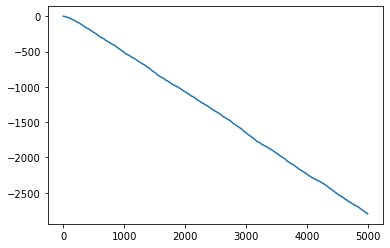

In [ ]:
xx['ccost'].plot()

<AxesSubplot:>

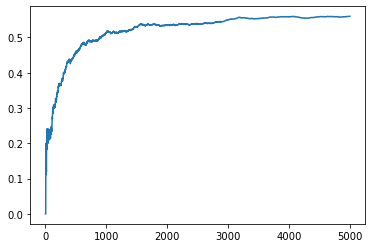

In [ ]:
xx['ctr'].plot()

In [ ]:
tempdf1 = xx.copy()

In [ ]:
context = pd.DataFrame(list(product(users, context1, context2, items)), columns=['users', 'context1', 'context2', 'items'])
context['reward'] = 0
X = context.copy()
X.loc[(X['users']=='usera')&(X['items']=='item1'),'reward']=1
X.loc[(X['users']=='userb')&(X['items']=='item2'),'reward']=1
X.loc[(X['users']=='userc')&(X['items']=='item3'),'reward']=1
X.reward.value_counts()

0    60
1    12
Name: reward, dtype: int64

In [ ]:
vws.update_context(X)

In [ ]:
_temp = []
for i in range(5000):
    _temp.append(vws.step())

In [ ]:
x = pd.DataFrame.from_records(_temp, columns=['user','context1','context2','item','cost','prob'])
xx = x.copy()
xx['ccost'] = xx['cost'].cumsum()
xx = xx.fillna(0)
xx = xx.rename_axis('iter').reset_index()
xx['ctr'] = -1*xx['ccost']/xx['iter']
xx.sample(10)

,iter,user,context1,context2,item,cost,prob,ccost,ctr
354,354,userc,ctx12,ctx21,item2,0,0.833333,-88,0.248588
3362,3362,userb,ctx11,ctx22,item2,-1,0.833333,-2481,0.737954
485,485,usera,ctx11,ctx22,item1,-1,0.833333,-171,0.352577
3383,3383,userb,ctx11,ctx22,item3,0,0.033333,-2499,0.738693
2803,2803,userc,ctx12,ctx21,item3,-1,0.833333,-2002,0.714235
3410,3410,userb,ctx12,ctx21,item3,0,0.033333,-2521,0.739296
267,267,usera,ctx12,ctx21,item4,0,0.033333,-54,0.202247
3848,3848,userb,ctx12,ctx21,item2,-1,0.833333,-2888,0.750520
54,54,userb,ctx12,ctx21,item6,0,0.833333,-13,0.240741
1447,1447,userc,ctx11,ctx21,item5,0,0.033333,-891,0.615757


In [ ]:
tempdf2 = tempdf1.append(xx, ignore_index=True)
tempdf2.sample(10)

,iter,user,context1,context2,item,cost,prob,ccost,ctr
8837,3837,usera,ctx12,ctx22,item1,-1,0.833333,-2879,0.750326
8210,3210,userc,ctx11,ctx21,item2,0,0.033333,-2348,0.731464
3280,3280,userb,ctx11,ctx21,item1,0,0.033333,-1822,0.555488
1029,1029,userc,ctx12,ctx21,item1,0,0.033333,-531,0.516035
4183,4183,userc,ctx12,ctx22,item2,0,0.033333,-2328,0.556538
2715,2715,userc,ctx11,ctx22,item4,-1,0.833333,-1467,0.540331
6300,1300,usera,ctx12,ctx21,item1,-1,0.833333,-776,0.596923
7111,2111,usera,ctx12,ctx21,item1,-1,0.833333,-1427,0.675983
4008,4008,usera,ctx11,ctx22,item5,-1,0.833333,-2239,0.558633
2236,2236,userc,ctx12,ctx21,item2,-1,0.833333,-1203,0.538014


<AxesSubplot:>

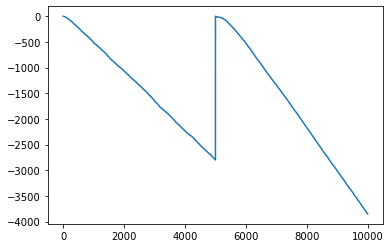

In [ ]:
tempdf2['ccost'].plot()

<AxesSubplot:>

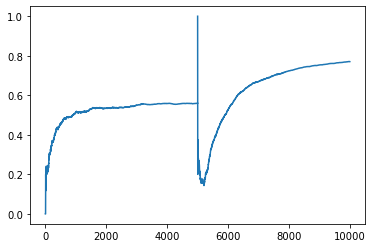

In [ ]:
tempdf2['ctr'].plot()

## Contextual bandit dash app
> Building a dash app of contextual bandit based recommender system

In [ ]:
!pip install -q dash dash-html-components dash-core-components dash_bootstrap_components jupyter-dash
!pip install -q vowpalwabbit

In [ ]:
!mkdir assets
!wget -O assets/image.jpg https://moodle.com/wp-content/uploads/2020/04/Moodle_General_news.png

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output, State
from jupyter_dash import JupyterDash
import plotly.graph_objs as go
import plotly.express as px

from vowpalwabbit import pyvw

import numpy as np
import pandas as pd
import itertools
import pathlib
from copy import deepcopy
from itertools import product
import scipy
import scipy.stats as stats
import random

In [ ]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label=None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User users={} context1={} context2={}\n".format(context["user"], context["context1"], context["context2"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action items={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context, actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob
def choose_user(users):
    return random.choice(users)
def choose_context1(context1):
    return random.choice(context1)
def choose_context2(context2):
    return random.choice(context2)

class VWCSimulation():
    def __init__(self, vw, ictxt):
        self.vw = vw
        self.users = ictxt['users'].unique().tolist()
        self.contexts1 = ictxt['context1'].unique().tolist()
        self.contexts2 = ictxt['context2'].unique().tolist()
        self.actions = ictxt['items'].unique().tolist()
        self.contextdf = ictxt.copy()
        self.contextdf['cost'] = self.contextdf['reward']*-1
        
    def get_cost(self, context, action):
        return self.contextdf.loc[(self.contextdf['users']==context['user']) & \
                (self.contextdf.context1==context['context1']) & \
                (self.contextdf.context2==context['context2']) & \
                (self.contextdf['items']==action), \
                'cost'].values[0]
    
    def update_context(self, new_ctxt):
        self.contextdf = new_ctxt.copy()
        self.contextdf['cost'] = self.contextdf['reward']*-1
    
    def step(self):
        user = choose_user(self.users)
        context1 = choose_context1(self.contexts1)
        context2 = choose_context2(self.contexts2)
        context = {'user': user, 'context1': context1, 'context2': context2}
        action, prob = get_action(self.vw, context, self.actions)
        cost = self.get_cost(context, action)
        vw_format = self.vw.parse(to_vw_example_format(context, self.actions, (action, cost, prob)), pyvw.vw.lContextualBandit)
        self.vw.learn(vw_format)
        self.vw.finish_example(vw_format)
        return (context['user'], context['context1'], context['context2'], action, cost, prob)

In [ ]:
app = JupyterDash(__name__, external_stylesheets = [dbc.themes.BOOTSTRAP])

def generate_input_cards(preference='Random'):
    card_content = [
    dbc.CardImg(src="assets/image.jpg", top=True),
    dbc.CardBody([html.P(preference, className="card-title")])
    ]
    card = dbc.Card(card_content, color="primary", outline=True)
    return dbc.Col([card], width={"size": 2})

pref_grid = []

mapping_users = {
    'Alex':'usera',
    'Ben':'userb',
    'Cindy': 'userc'
}
    
mapping_context1 = {
    'Morning':'ctx11',
    'Evening':'ctx12',
}

mapping_context2 = {
    'Weekday':'ctx21',
    'Weekend':'ctx22'
}

mapping_items = {
    'Politics':'item1',
    'Economics':'item2',
    'Technology':'item3',
    'Weather':'item4',
    'Business':'item5',
    'History':'item6'
}

mapping_users_reverse = {v:k for k,v in mapping_users.items()}
mapping_context1_reverse = {v:k for k,v in mapping_context1.items()}
mapping_context2_reverse = {v:k for k,v in mapping_context2.items()}
mapping_items_reverse = {v:k for k,v in mapping_items.items()}

users = list(mapping_users.values())
items = list(mapping_items.values())
context1 = list(mapping_context1.values())
context2 = list(mapping_context2.values())

context = pd.DataFrame(list(product(users, context1, context2, items)),
                       columns=['users', 'context1', 'context2', 'items'])
context['reward'] = np.random.choice([0,1],len(context),p=[0.8,0.2])

vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")
vws = VWCSimulation(vw, context)
last_update = vws.step()

contextdf = context.copy()
countDF = contextdf.copy()
countDF['prob'] = 0

def generate_input_boxes():
    dropdown_users = dcc.Dropdown(
        id='ddown_users',
        options=[{"label":k, "value":v} for k,v in mapping_users.items()],
        clearable=False,
        value="usera",
        className="m-1",
    )
    dropdown_context1 = dcc.Dropdown(
        id='ddown_ctx1',
        options=[{"label":k, "value":v} for k,v in mapping_context1.items()],
        clearable=False,
        value="ctx11",
        className="m-1",
    )
    dropdown_context2 = dcc.Dropdown(
        id='ddown_ctx2',
        options=[{"label":k, "value":v} for k,v in mapping_context2.items()],
        clearable=False,
        value="ctx21",
        className="m-1",
    )
    dropdown_items = dcc.Dropdown(
        id='ddown_items',
        options=[{"label":k, "value":v} for k,v in mapping_items.items()],
        clearable=False,
        value="item1",
        className="m-1",
    )
    return html.Div(
        [
            dropdown_users,
            dropdown_context1,
            dropdown_context2,
            dropdown_items,
        ],
        style={"display": "flex", "flex-direction": "column"},
    )

def generate_context_boxes():
    dropdown_outcontext1 = dcc.Dropdown(
        id='ddown_outctx1',
        options=[{"label":k, "value":v} for k,v in mapping_context1.items()],
        clearable=False,
        value="ctx11",
        className="m-1",
    )
    dropdown_outcontext2 = dcc.Dropdown(
        id='ddown_outctx2',
        options=[{"label":k, "value":v} for k,v in mapping_context2.items()],
        clearable=False,
        value="ctx21",
        className="m-1",
    )
    return html.Div(
        [
            dropdown_outcontext1,
            dropdown_outcontext2
        ],
        style={"display": "flex", "flex-direction": "column"},
    )

app.layout = html.Div([
        generate_input_boxes(),
        dbc.Button("Register your Preference", color="primary", className="m-1", 
                   id='pref-button', block=True),
        html.Div(id='pref-grid'),
        dbc.Button("Clear the context", color="secondary", 
                   className="m-1", id='clr-button', block=True),
        dbc.Button("Start rewarding Agent for these Preferences", color="success", 
                   className="m-1", id='updt-button', block=True),
        generate_context_boxes(),
        dcc.Interval(
            id='interval-component',
            interval=100, # in milliseconds
            n_intervals=0),
        html.Div(id='placeholder'),
        html.Div(id='placeholder2'),

])

@app.callback(
    Output("pref-grid", "children"),
    Input("pref-button", "n_clicks"),   
    Input("clr-button", "n_clicks"),
    State('ddown_users', 'value'),
    State('ddown_items', 'value'),
    State('ddown_ctx1', 'value'), 
    State('ddown_ctx2', 'value'),
)
def update_pref_grid(nclick_pref, nclick_clr, pref_user, pref_item, pref_ctx1, pref_ctx2):
    global pref_grid
    changed_id = [p['prop_id'] for p in dash.callback_context.triggered][0]
    if "pref-button" in changed_id:
        global contextdf
        card_text = '{} prefers {} related news in {} {}s'.format(mapping_users_reverse[pref_user],
                                                  mapping_items_reverse[pref_item],
                                                  mapping_context2_reverse[pref_ctx2],
                                                  mapping_context1_reverse[pref_ctx1])
        
        contextdf.loc[(contextdf.users==pref_user) & \
            (contextdf.context1==pref_ctx1) & \
            (contextdf.context2==pref_ctx2), \
            'reward'] = 0
        contextdf.loc[(contextdf.users==pref_user) & \
            (contextdf.context1==pref_ctx1) & \
            (contextdf.context2==pref_ctx2) & \
            (contextdf['items']==pref_item), \
            'reward'] = 1
        pref_grid.append(generate_input_cards(card_text))
        return dbc.Row(children=pref_grid,
                      style={'max-width': '100%',
                             'display': 'flex',
                             'align-items': 'center',
                             'padding': '2rem 5rem',
                             'overflow': 'auto',
                             'height': 'fit-content',
                             'flex-direction': 'row',
                            })
    elif "clr-button" in changed_id:
        pref_grid = []
        return dbc.Row(children=pref_grid)

@app.callback(
    Output("placeholder2", "children"),
    Input("updt-button", "n_clicks")
)
def update_context(nclick):
    if nclick:
        global vws
        global contextdf
        vws.update_context(contextdf)
    return ''


@app.callback(
    Output("placeholder", "children"),
    Input('interval-component', 'n_intervals'),
    Input('ddown_outctx1', 'value'), 
    Input('ddown_outctx2', 'value'),
)
def update_metrics(n, octx1, octx2):
    global countDF
    countDF = countDF.append(pd.Series(vws.step(),countDF.columns),ignore_index=True)
    _x = countDF.copy()
    _x = _x[(_x.context1==octx1) & (_x.context2==octx2)]
    _x['reward']*=-1
    pv = pd.pivot_table(_x, index=['users'], columns=["items"], values=['reward'], aggfunc=sum, fill_value=0)
    pv.index = [mapping_users_reverse[x] for x in pv.index]
    pv.columns = pv.columns.droplevel(0)
    pv = pv.rename_axis('User').reset_index().rename_axis(None, axis=1).set_index('User').T.reset_index()
    pv['index'] = pv['index'].map(mapping_items_reverse)
    pv = pv.rename(columns={"index": "Preferences"})
    out = html.Div([
        dbc.Table.from_dataframe(pv, striped=True, bordered=True, hover=True, responsive=True)
    ])
    return out

In [ ]:
app.run_server(mode='inline', port=8081)

<IPython.core.display.Javascript object>

In [ ]:
# !kill -9 $(lsof -t -i:8081) # command to kill the dash once done